# Investigating Vix Levels And Returns

## Python Imports

In [61]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
import warnings
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
warnings.filterwarnings("ignore")

## Python Functions

In [62]:
# This function pulls data from Yahoo finance
import pandas as pd
import numpy as np
import yfinance as yf

def yf_data_updater(fund):
    # Download data from YF
    df_comp = yf.download(fund)
    
    # Reset index
    df_comp.reset_index(inplace = True)
    
    # Drop data from last day because it's not accrate until end of day
    df_comp.drop(df_comp.index[-1], inplace=True)
    
    # Reset date column
    df_comp['Date'] = df_comp['Date'].dt.tz_localize(None)
    
    # Set index to date
    df_comp.set_index('Date', inplace = True)
    
    # Export data to excel
    file = fund + ".xlsx"
    df_comp.to_excel(file, sheet_name='data')

    print(f"The last date of data for {fund} is: ")
    print(df_comp[-1:])
    print(f"Data updater complete for {fund} data")
    return print(f"--------------------")

In [63]:
yf_data_updater('^VIX')

[*********************100%***********************]  1 of 1 completed


The last date of data for ^VIX is: 
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2024-12-02 14.08 14.10 13.30  13.34      13.34       0
Data updater complete for ^VIX data
--------------------


In [64]:
# Set number of decimal places in pandas
def dp(decimal_places):
    pd.set_option('display.float_format', lambda x: f'%.{decimal_places}f' % x)

dp(2)

In [65]:
def load_data(file):
    # Import CSV
    try:
        df = pd.read_csv(file)
    except:
        pass

    # Import excel
    try:
        df = pd.read_excel(file, sheet_name='data', engine='openpyxl')
    except:
        pass
        
    return df

In [66]:
# The `df_info` function returns some useful information about a dataframe, such as the columns, data types, and size.
def df_info(df):
    print('There are ', df.shape[0], ' rows and ', df.shape[1], ' columns')
    print('The columns and data types are:')
    print(df.dtypes)
    print('The first 4 rows are:')
    display(df.head(4))
    print('The last 4 rows are:')
    display(df.tail(4))

## Import Data

### CBOE Volatility Index (VIX)

In [67]:
# VIX
vix = load_data('^VIX.xlsx')

# Set 'Date' column as datetime
vix['Date'] = pd.to_datetime(vix['Date'])

# Drop 'Volume' and 'Adj Close'
vix.drop(columns = {'Adj Close', 'Volume'}, inplace = True)

# Set Date as index
vix.set_index('Date', inplace = True)

In [68]:
# Check to see if there are any NaN values
vix[vix['High'].isna()]

# Forward fill to clean up missing data
vix['High'].ffill(inplace = True)

In [69]:
df_info(vix)

There are  8797  rows and  4  columns
The columns and data types are:
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
The first 4 rows are:


,Open,High,Low,Close
Date,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11


The last 4 rows are:


,Open,High,Low,Close
Date,,,,
2024-11-26,14.95,15.03,13.88,14.10
2024-11-27,14.28,15.13,13.96,14.10
2024-11-29,14.00,14.15,13.49,13.51
2024-12-02,14.08,14.10,13.30,13.34


In [70]:
vix_stats = vix.describe()

In [71]:
vix_stats.loc['mean + 1 std'] = {'Open': vix_stats.loc['mean']['Open'] + vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + vix_stats.loc['std']['Close']}
vix_stats.loc['mean + 2 std'] = {'Open': vix_stats.loc['mean']['Open'] + 2 * vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + 2 * vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + 2 * vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + 2 * vix_stats.loc['std']['Close']}
vix_stats.loc['mean - 1 std'] = {'Open': vix_stats.loc['mean']['Open'] - vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] - vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] - vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] - vix_stats.loc['std']['Close']}

In [72]:
vix_stats

,Open,High,Low,Close
count,8797.00,8797.00,8797.00,8797.00
mean,19.57,20.37,18.81,19.48
std,7.92,8.39,7.42,7.85
min,9.01,9.31,8.56,9.14
25%,13.91,14.48,13.38,13.83
50%,17.67,18.32,17.06,17.63
75%,22.97,23.81,22.15,22.84
max,82.69,89.53,72.76,82.69
mean + 1 std,27.49,28.76,26.23,27.33
mean + 2 std,35.41,37.15,33.64,35.17


In [73]:
deciles = vix.quantile(np.arange(0, 1.1, 0.1))
display(deciles)

,Open,High,Low,Close
0.00,9.01,9.31,8.56,9.14
0.10,12.12,12.61,11.71,12.10
0.20,13.27,13.85,12.82,13.22
0.30,14.62,15.25,14.04,14.56
0.40,16.11,16.73,15.53,16.07
0.50,17.67,18.32,17.06,17.63
0.60,19.68,20.38,19.02,19.55
0.70,21.78,22.63,21.00,21.63
0.80,24.39,25.32,23.52,24.32
0.90,28.86,29.99,27.78,28.69


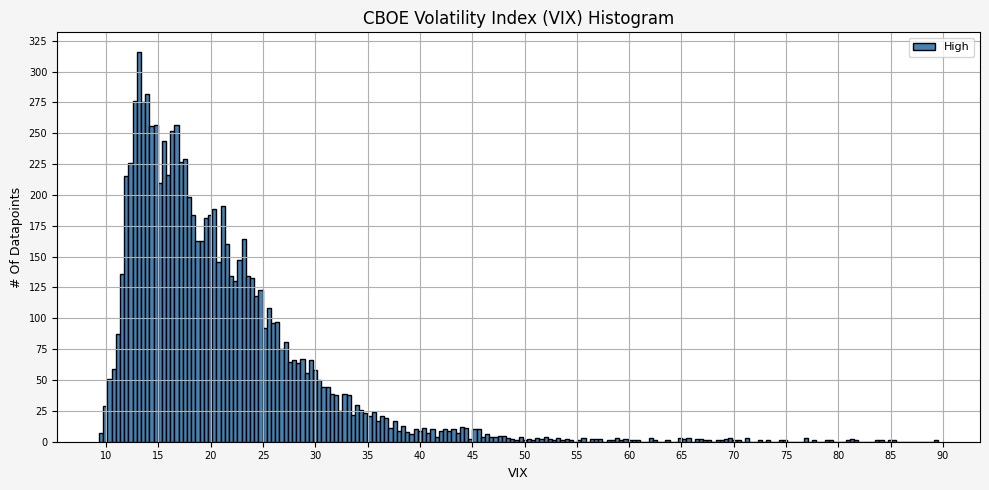

In [74]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.hist([vix['High']], 
         label=['High'], bins=200, edgecolor='black', color='steelblue')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('VIX', fontsize = 9)
plt.xticks(rotation = 0, fontsize = 7)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('# Of Datapoints', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX) Histogram', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('04_Histogram.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

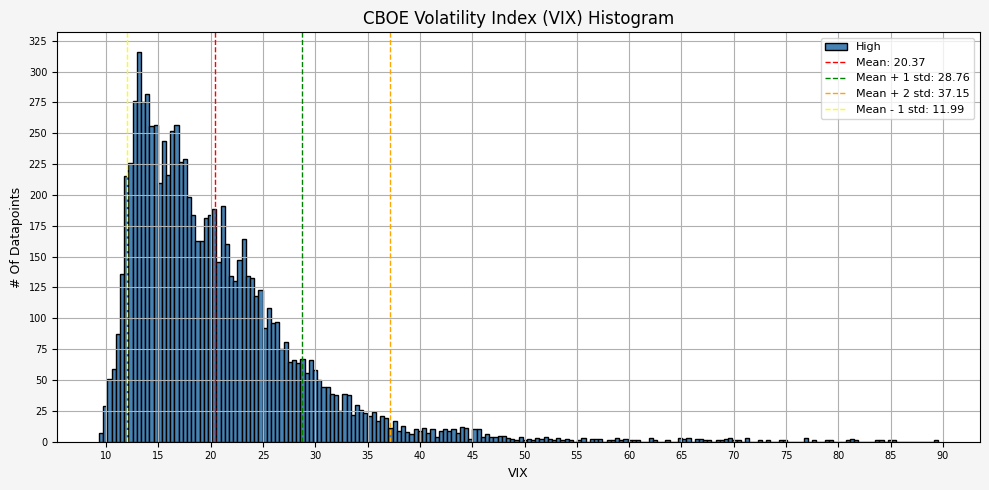

In [75]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.hist([vix['High']], 
         label=['High'], bins=200, edgecolor='black', color='steelblue')

# Plot a vertical line at the mean, mean + 1 std, and mean + 2 std
plt.axvline(vix_stats.loc['mean']['High'], color='red', linestyle='dashed', linewidth=1, label=f'Mean: {vix_stats.loc['mean']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 1 std']['High'], color='green', linestyle='dashed', linewidth=1, label=f'Mean + 1 std: {vix_stats.loc['mean + 1 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 2 std']['High'], color='orange', linestyle='dashed', linewidth=1, label=f'Mean + 2 std: {vix_stats.loc['mean + 2 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean - 1 std']['High'], color='yellow', linestyle='dashed', linewidth=1, label=f'Mean - 1 std: {vix_stats.loc['mean - 1 std']['High']:.2f}')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('VIX', fontsize = 9)
plt.xticks(rotation = 0, fontsize = 7)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('# Of Datapoints', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX) Histogram', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('05_Histogram+Mean.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Plots

### CBOE Volatility Index (VIX)

#### 1990 - 2009

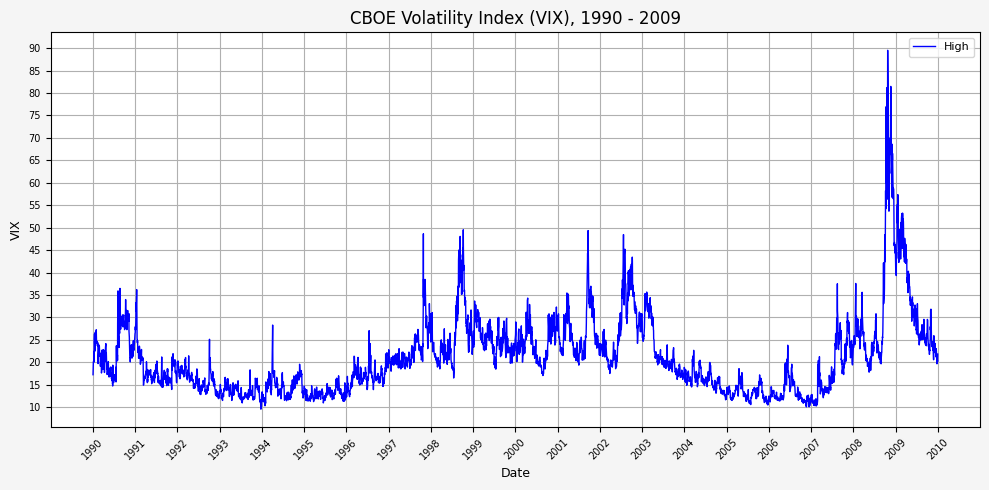

In [76]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(vix[vix.index <= '2009-12-31'].index, vix[vix.index <= '2009-12-31']['High'], label='High', linestyle='-', color='b', linewidth=1)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('VIX', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX), 1990 - 2009', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('06_Plot_1990-2009.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

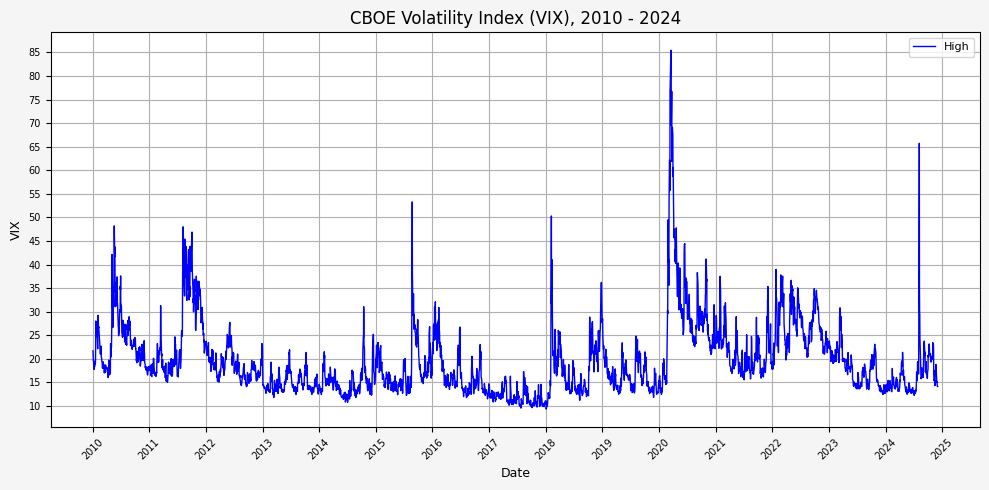

In [77]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(vix[vix.index > '2009-12-31'].index, vix[vix.index > '2009-12-31']['High'], label='High', linestyle='-', color='b', linewidth=1)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('VIX', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX), 2010 - 2024', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('07_Plot_2010-2024.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Determining A Spike Level

In [78]:
# Define the spike multiplier for detecting significant spikes
spike_level = 1.25

# =========================
# Simple Moving Averages (SMA)
# =========================

# Calculate 10-period SMA of 'High'
vix['High_SMA_10'] = vix['High'].rolling(window=10).mean()

# Shift the 10-period SMA by 1 to compare with current 'High'
vix['High_SMA_10_Shift'] = vix['High_SMA_10'].shift(1)

# Calculate the spike level based on shifted SMA and spike multiplier
vix['Spike_Level_SMA'] = vix['High_SMA_10_Shift'] * spike_level

# Calculate 20-period SMA of 'High'
vix['High_SMA_20'] = vix['High'].rolling(window=20).mean()

# Determine if 'High' exceeds the spike level (indicates a spike)
vix['Spike_SMA'] = vix['High'] >= vix['Spike_Level_SMA']

# Calculate 50-period SMA of 'High' for trend analysis
vix['High_SMA_50'] = vix['High'].rolling(window=50).mean()

# =========================
# Exponential Moving Averages (EMA)
# =========================

# Calculate 10-period EMA of 'High'
vix['High_EMA_10'] = vix['High'].ewm(span=10, adjust=False).mean()

# Shift the 10-period EMA by 1 to compare with current 'High'
vix['High_EMA_10_Shift'] = vix['High_EMA_10'].shift(1)

# Calculate the spike level based on shifted EMA and spike multiplier
vix['Spike_Level_EMA'] = vix['High_EMA_10_Shift'] * spike_level

# Calculate 20-period EMA of 'High'
vix['High_EMA_20'] = vix['High'].ewm(span=20, adjust=False).mean()

# Determine if 'High' exceeds the spike level (indicates a spike)
vix['Spike_EMA'] = vix['High'] >= vix['Spike_Level_EMA']

# Calculate 50-period EMA of 'High' for trend analysis
vix['High_EMA_50'] = vix['High'].ewm(span=50, adjust=False).mean()


In [79]:
vix.head(60)

,Open,High,Low,Close,High_SMA_10,High_SMA_10_Shift,Spike_Level_SMA,High_SMA_20,Spike_SMA,High_SMA_50,High_EMA_10,High_EMA_10_Shift,Spike_Level_EMA,High_EMA_20,Spike_EMA,High_EMA_50
Date,,,,,,,,,,,,,,,,
1990-01-02,17.24,17.24,17.24,17.24,NaN,NaN,NaN,NaN,False,NaN,17.24,NaN,NaN,17.24,False,17.24
1990-01-03,18.19,18.19,18.19,18.19,NaN,NaN,NaN,NaN,False,NaN,17.41,17.24,21.55,17.33,False,17.28
1990-01-04,19.22,19.22,19.22,19.22,NaN,NaN,NaN,NaN,False,NaN,17.74,17.41,21.77,17.51,False,17.35
1990-01-05,20.11,20.11,20.11,20.11,NaN,NaN,NaN,NaN,False,NaN,18.17,17.74,22.18,17.76,False,17.46
1990-01-08,20.26,20.26,20.26,20.26,NaN,NaN,NaN,NaN,False,NaN,18.55,18.17,22.71,18.00,False,17.57
1990-01-09,22.20,22.20,22.20,22.20,NaN,NaN,NaN,NaN,False,NaN,19.21,18.55,23.19,18.40,False,17.75
1990-01-10,22.44,22.44,22.44,22.44,NaN,NaN,NaN,NaN,False,NaN,19.80,19.21,24.02,18.78,False,17.94
1990-01-11,20.05,20.05,20.05,20.05,NaN,NaN,NaN,NaN,False,NaN,19.85,19.80,24.75,18.90,False,18.02
1990-01-12,24.64,24.64,24.64,24.64,NaN,NaN,NaN,NaN,False,NaN,20.72,19.85,24.81,19.45,False,18.28


### Spike Totals By Year

In [84]:
# Ensure the index is a DatetimeIndex
vix.index = pd.to_datetime(vix.index)

# Create a new column for the year extracted from the date index
vix['Year'] = vix.index.year

# Group by year and the "Spike_SMA" and "Spike_EMA" columns, then count occurrences
spike_count = vix.groupby(['Year', 'Spike_SMA']).size().unstack(fill_value=0)

spike_count

Spike_SMA,False,True
Year,,
1990,248,5
1991,249,4
1992,250,4
1993,251,2
1994,243,9
1995,252,0
1996,248,6
1997,247,6
1998,243,9


In [59]:
spike_count.columns

Index([False, True], dtype='bool', name='Spike')

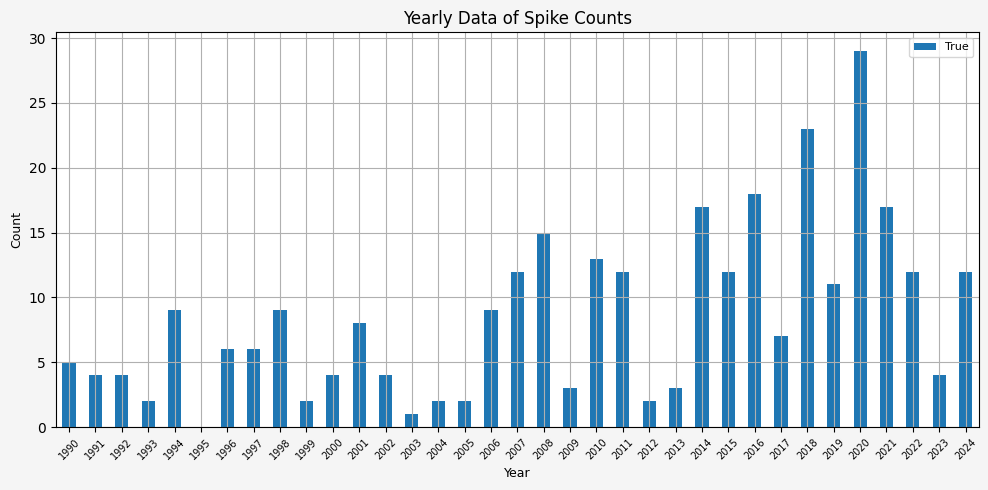

In [60]:
# Plotting the spike counts
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

spike_count[True].plot(kind='bar', stacked=False)

# # Set X axis
# x_tick_spacing = 5  # Specify the interval for y-axis ticks
# plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('Year', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# # Set Y axis
# y_tick_spacing = 25  # Specify the interval for y-axis ticks
# plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('Count', fontsize = 9)
# plt.yticks(fontsize = 7)

# # Set title, etc.
plt.title('Yearly Data of Spike Counts')

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('08_Spike_Counts.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [23]:
def vix_plot(start_year, end_year):
    start_date = start_year + '-01-01'
    end_date = end_year + '-12-31'

    vix_temp = vix[(vix.index >= start_date) & (vix.index <= end_date)]

    # Plotting the VIX
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    plt.plot(vix_temp.index, vix_temp['High'], label='High', linestyle='-', color='b', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['Low'], label='Low', linestyle='-', color='y', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_10'], label='10 Day High SMA', linestyle='-', color='r', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_20'], label='20 Day High SMA', linestyle='-', color='orange', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_50'], label='50 Day High SMA', linestyle='-', color='g', linewidth=1)
    plt.scatter(vix_temp[vix_temp['Spike'] == True].index, vix_temp[vix_temp['Spike'] == True]['High'], label='Spike (High > 1.25 * 10 Day High SMA)', linestyle='-', color='g', s=10)

    # Set X axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xlabel('Date', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)

    # Set Y axis
    y_tick_spacing = 5  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.ylabel('VIX', fontsize = 9)
    plt.yticks(fontsize = 7)

    # Set title, etc.
    plt.title(f'CBOE Volatility Index (VIX), {start_year} - {end_year}', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize = 8)
    plt.show()

#### 1990

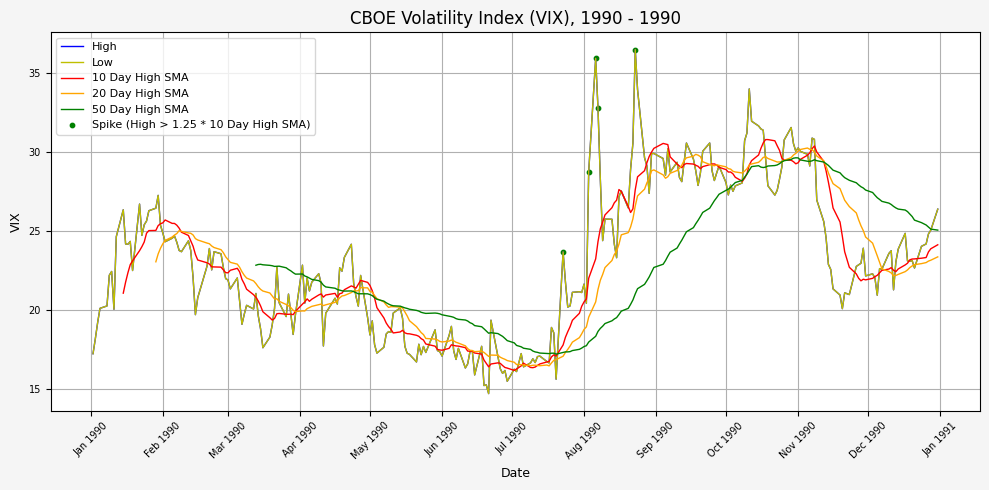

In [24]:
vix_plot('1990', '1990')

#### 1999

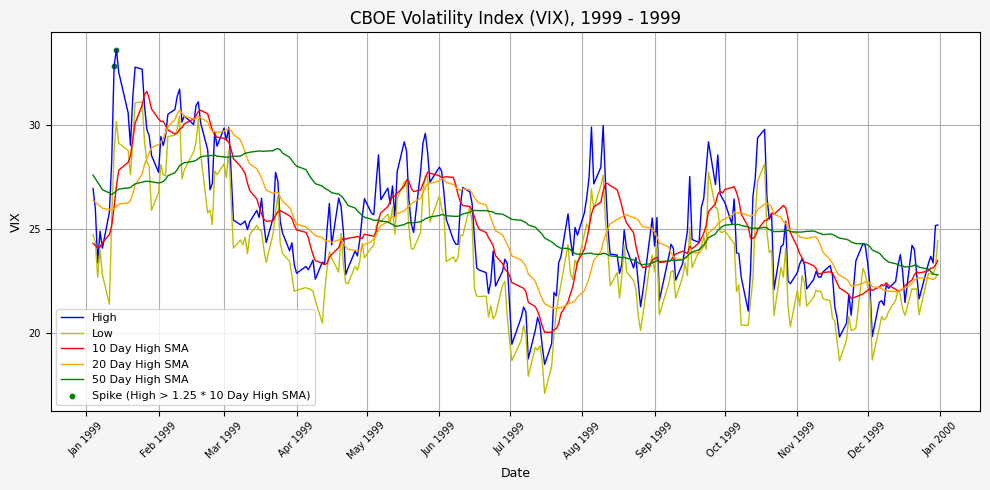

In [25]:
vix_plot('1999', '1999')

#### 2011

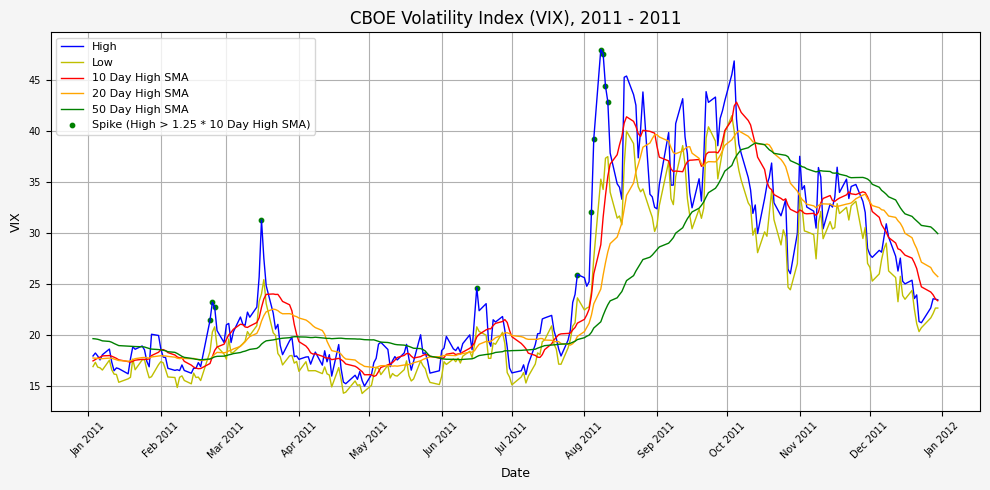

In [26]:
vix_plot('2011', '2011')

#### 2018

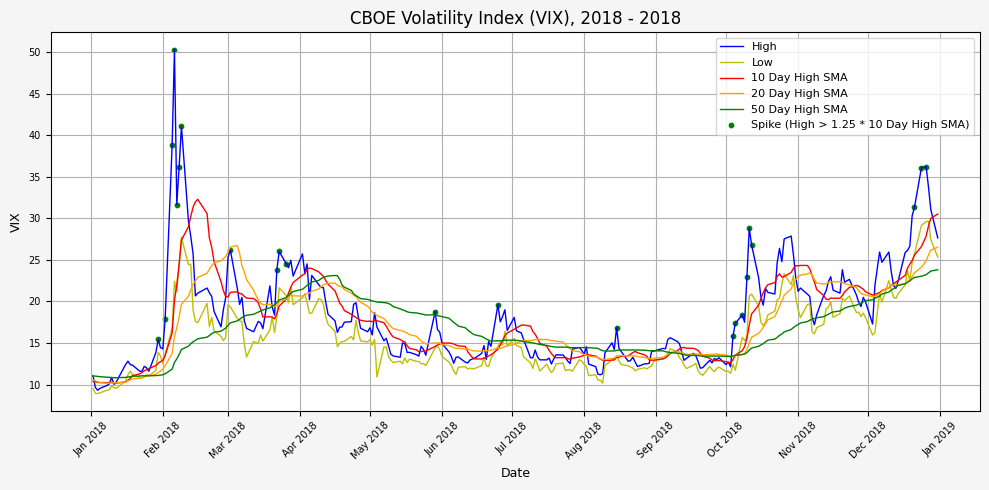

In [27]:
vix_plot('2018', '2018')

#### 2019

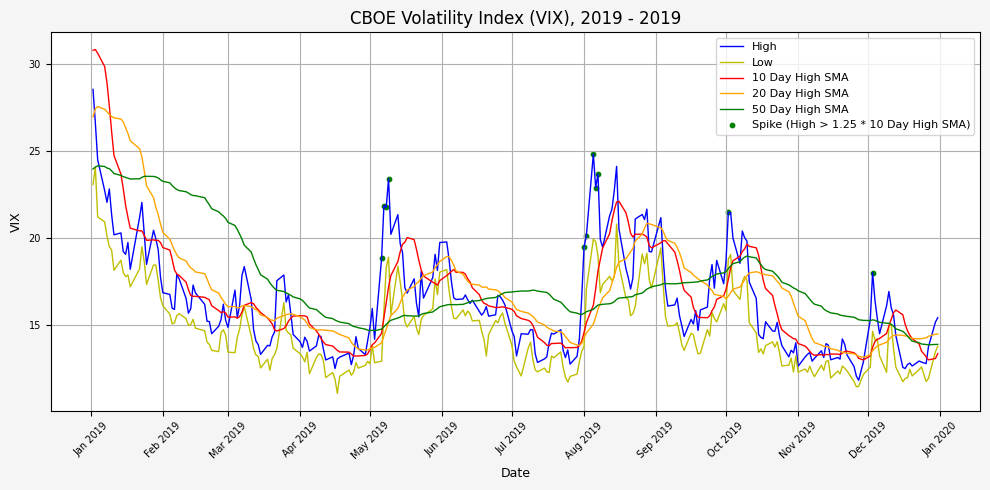

In [28]:
vix_plot('2019', '2019')

#### 2020

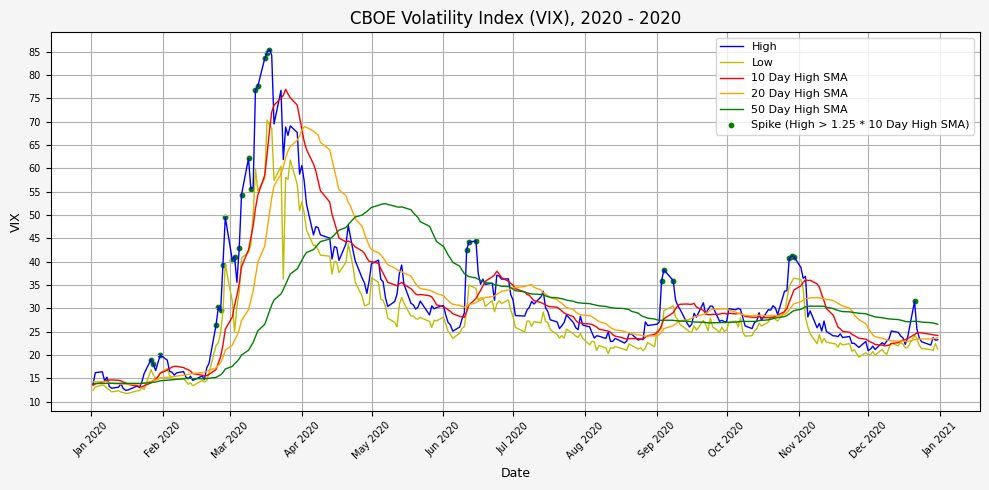

In [29]:
vix_plot('2020', '2020')

#### 2021

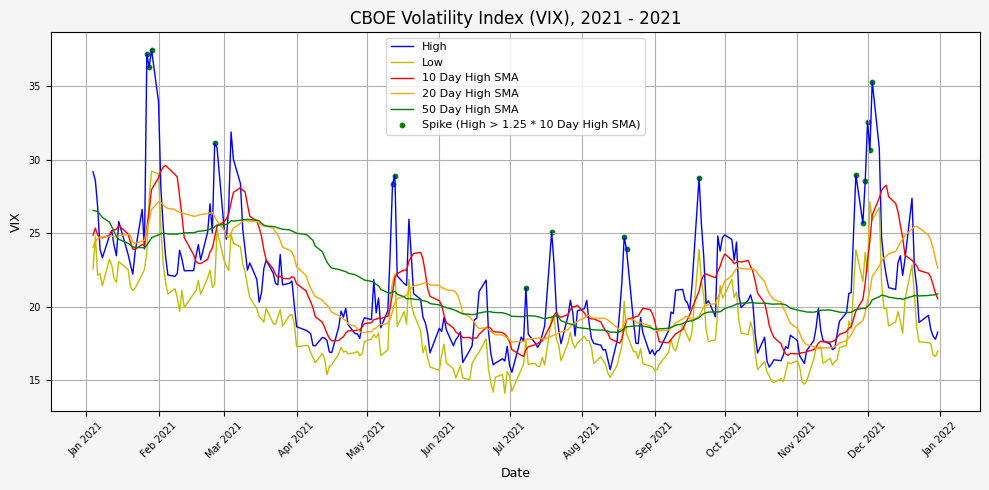

In [30]:
vix_plot('2021', '2021')

#### 2022

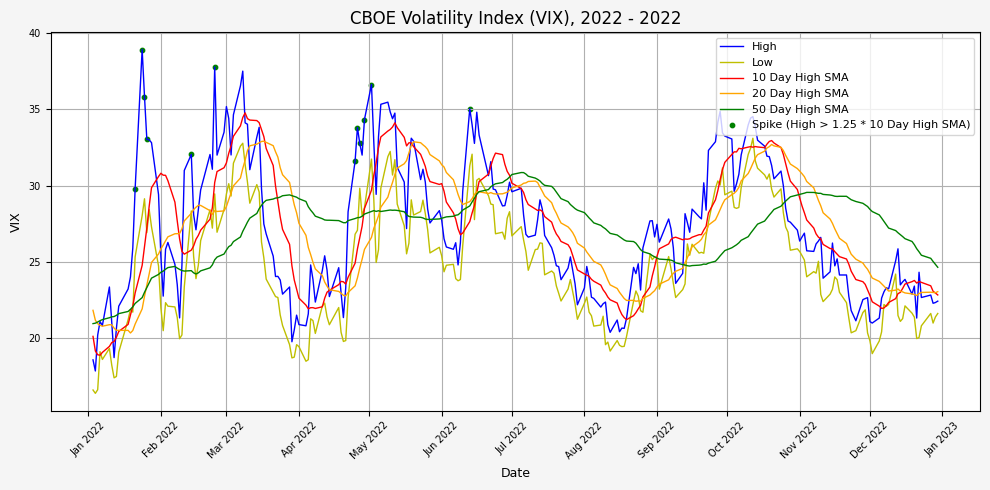

In [31]:
vix_plot('2022', '2022')

#### 2023

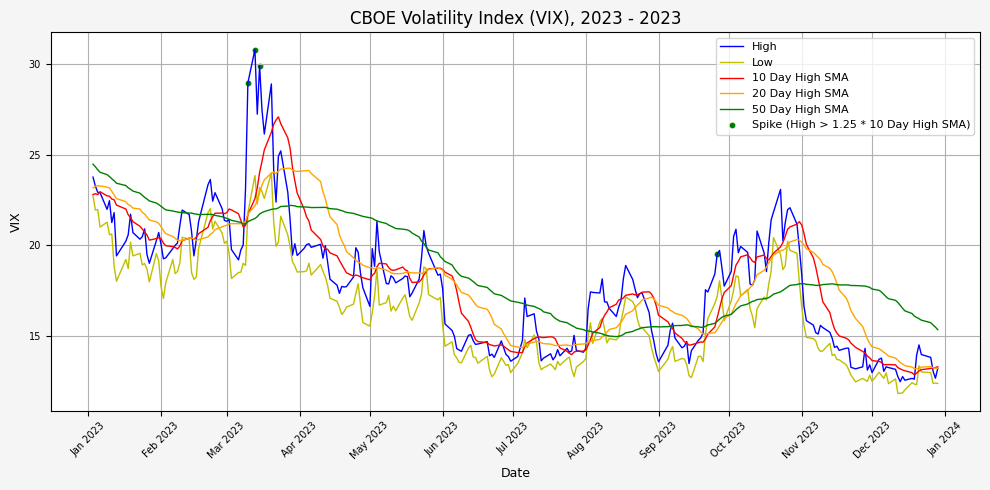

In [32]:
vix_plot('2023', '2023')

#### 2024

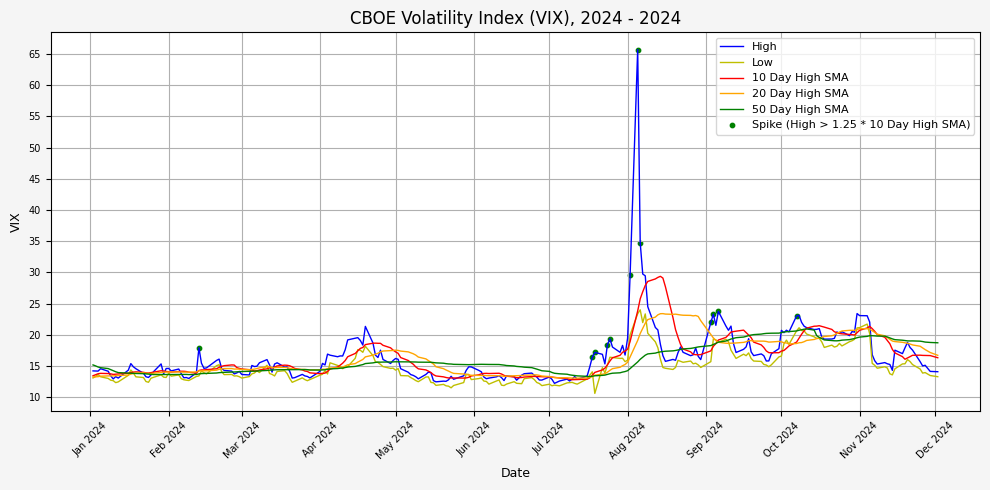

In [34]:
vix_plot('2024', '2024')

#### 2020 - 2024

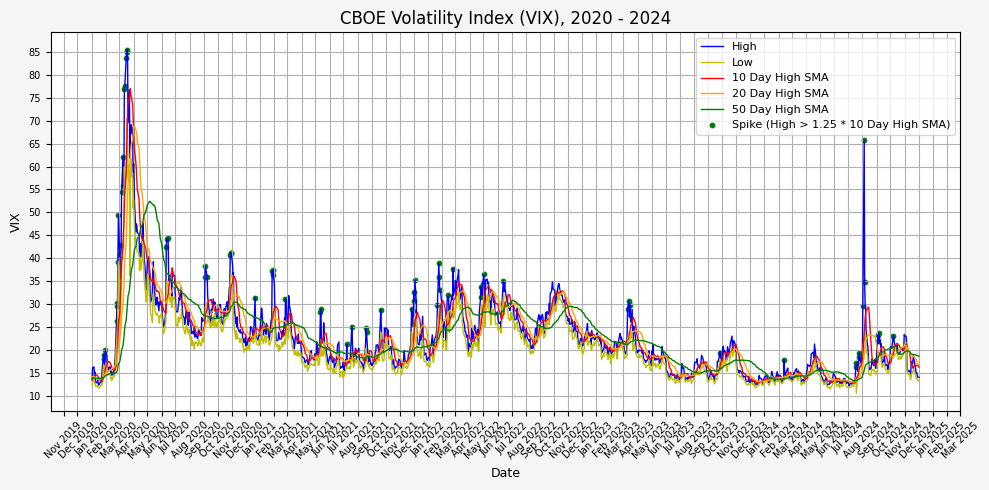

In [35]:
vix_plot('2020', '2024')

In [37]:
vix[(vix['Spike'] == True) & (vix.index >= '2024-01-01')]

,Open,High,Low,Close,SMA_10,SMA_10_Shift,Spike_Level,Spike,SMA_20,SMA_50,Year
Date,,,,,,,,,,,
2024-02-13,13.96,17.94,13.43,15.85,14.30,13.88,17.35,True,14.25,13.75,2024
2024-07-18,14.27,16.43,14.08,15.93,13.53,13.11,16.39,True,13.36,13.38,2024
2024-07-19,16.44,17.19,10.62,16.52,13.99,13.53,16.91,True,13.54,13.45,2024
2024-07-24,15.35,18.46,15.18,18.04,15.22,14.66,18.33,True,14.02,13.67,2024
2024-07-25,18.41,19.36,16.42,18.46,15.82,15.22,19.02,True,14.32,13.78,2024
2024-08-02,20.52,29.66,20.01,23.39,18.95,17.71,22.13,True,16.47,14.61,2024
2024-08-05,23.39,65.73,23.39,38.57,23.84,18.95,23.69,True,19.11,15.66,2024
2024-08-06,33.71,34.77,24.02,27.71,25.78,23.84,29.80,True,20.22,16.09,2024
2024-09-03,15.76,21.99,15.71,20.72,17.43,16.84,21.05,True,20.09,18.28,2024


In [38]:
vix.tail(20)

,Open,High,Low,Close,SMA_10,SMA_10_Shift,Spike_Level,Spike,SMA_20,SMA_50,Year
Date,,,,,,,,,,,
2024-11-04,22.50,23.07,21.73,21.98,21.11,20.74,25.92,False,20.99,19.77,2024
2024-11-05,21.98,22.06,20.20,20.49,21.37,21.11,26.39,False,20.94,19.87,2024
2024-11-06,16.06,16.82,15.44,16.27,21.01,21.37,26.71,False,20.68,19.87,2024
2024-11-07,15.86,15.86,15.13,15.20,20.57,21.01,26.26,False,20.40,19.83,2024
2024-11-08,15.13,15.33,14.66,14.94,20.05,20.57,25.71,False,20.11,19.81,2024
2024-11-11,15.33,15.56,14.89,14.97,19.62,20.05,25.06,False,19.85,19.80,2024
2024-11-12,15.09,15.37,14.69,14.71,19.10,19.62,24.52,False,19.57,19.67,2024
2024-11-13,15.09,15.26,13.77,14.02,18.58,19.10,23.88,False,19.28,19.50,2024
2024-11-14,14.17,14.32,13.59,14.31,17.67,18.58,23.23,False,19.02,19.36,2024
